In [143]:
#Importar las librerías por utilizar
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage import io
from skimage.transform import resize
from skimage.filters import threshold_otsu,sobel,sobel_v,sobel_h
from skimage.feature import canny
from skimage.color import rgb2hsv
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from matplotlib import cm

#Obtener la direccion de las imagenes
path = os.getcwd()

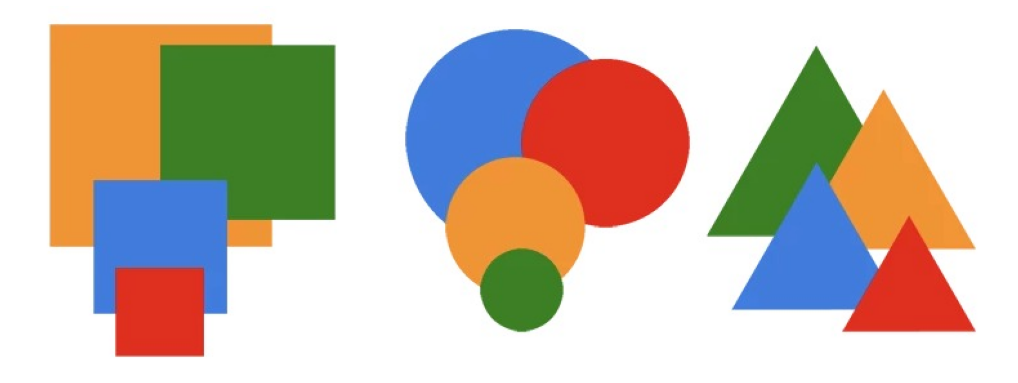

tamaño: (287, 780, 3)


In [144]:
#Imagen original
file_path = os.path.join(path , 'Imagen_a_utilizar.jpeg')
img_org = io.imread(file_path)
shape = img_org.shape

plt.figure(figsize = (18,24))
plt.imshow(img_org)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_org.shape))

In [145]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

n_colors = 5
SUM_WHITE = 762

# Load the Summer Palace photo
china = img_org

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
COLORES = np.rint(np.array(kmeans.cluster_centers_, dtype=np.float64) *255)
COLORES = COLORES.tolist()
for COLOR in COLORES:
    if COLOR[0]+COLOR[1]+COLOR[2] >= SUM_WHITE:
        COLORES.remove(COLOR)
COLORES = np.array(COLORES)
print(COLORES)


[[ 69. 124. 216.]
 [237. 150.  60.]
 [ 63. 127.  39.]
 [221.  48.  33.]]


In [155]:
#SEEDS  = (UP,DOWN,RIGHT,LEFT,CENTER)
#SEED_COLORS  = (UP_COLOR,DOWN_COLOR,RIGHT_COLOR,LEFT_COLOR,CENTER_COLOR)
# 8-vecindad
VECINDAD = [
    (-1,-1), (-1, 0), (-1, 1),
    ( 0,-1),          ( 0, 1),
    ( 1,-1), ( 1, 0), ( 1, 1)]

# imagen de pixeles visitados, evita revisitar pixeles
visitado = np.zeros(shape=(shape[0],shape[1],1), dtype=np.uint8)

MAX_SUM_COLOR = 20

# Crea un región con una semilla y actualiza la imagen out_img
# con la región nueva y su color específico
def region_growth(
    seed,img,
    out_img = np.zeros(shape=shape, dtype=np.uint8)):  
    h, w = shape[:2]
    region = [seed]
    # Identifica el color de la region
    x = seed[0]
    y = seed[1]
    for COLOR in COLORES:
        sum = abs(img[y][x][0]-COLOR[0])+abs(img[y][x][1]-COLOR[1])+abs(img[y][x][2]-COLOR[2])
        if sum < MAX_SUM_COLOR:
            seed_color = COLOR
            out_img[y][x] = seed_color

    # Crecimiento de la región
    while len(region):
        seed = region.pop(0)
        x = seed[0]
        y = seed[1]
        # Marca la semilla como visitada
        visitado[y][x] = 1
        for vecino in VECINDAD:
            cur_x = x + vecino[0]
            cur_y = y + vecino[1]
            # limites de la imagen
            if cur_x <0 or cur_y<0 or cur_x >= w or cur_y >=h :
                continue
            # crea nueva semilla si el pixel actual es igual a la semilla
            # y si aun no está visitado, marca pixel actual como visitado
            sum = abs(img[cur_y][cur_x][0]-seed_color[0])+abs(img[cur_y][cur_x][1]-seed_color[1])+abs(img[cur_y][cur_x][2]-seed_color[2])
            #print(abs(sum))
            if (not visitado[cur_y][cur_x]) and (sum < MAX_SUM_COLOR):
                out_img[cur_y][cur_x] = seed_color
                visitado[cur_y][cur_x] = 1
                region.append((cur_x,cur_y))
    return out_img,seed_color


se = (150,100)
imgreg = region_growth(se,img_org)[0]
se = (100,100)
imgreg = region_growth(se,img_org,imgreg)[0]
se = (150,150)
imgreg = region_growth(se,img_org,imgreg)[0]
se = (100,250)
imgreg = region_growth(se,img_org,imgreg)[0]

plt.figure(figsize = (18,24))
plt.imshow(imgreg)

    

IndexError: invalid index to scalar variable.

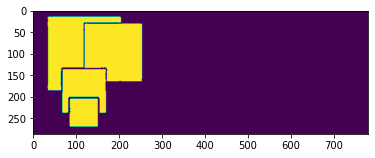

In [147]:
plt.imshow(visitado)

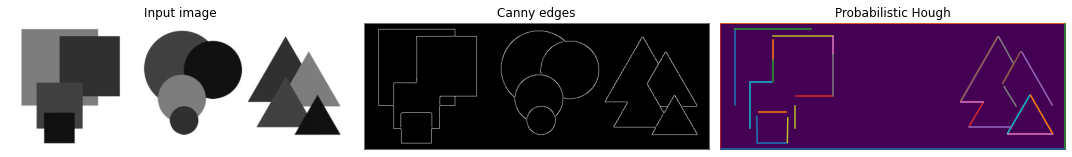

In [148]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
image = img_org = io.imread(file_path,True)
edges = canny(image,1,0.1,0.2)
#edges = sobel(image)
lines = probabilistic_hough_line(edges, threshold=10, line_length=40,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()